# IREI: Profile-based retrieval
### Víctor Morcuende Castell and Guillermo Nájera Lavid
#### Course 2022-2023

### Preprocessing Phase

In [1]:
import nltk

nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /Users/victor/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/victor/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to
[nltk_data]

True

In [2]:
# Read the data
import pandas as pd

train_data = pd.read_csv('dataset/BBC News Train.csv')
test_data = pd.read_csv('dataset/BBC News Test.csv')

# Transform the data into a single dataset
data = pd.concat([train_data,test_data])
data.to_csv('dataset/data.csv', index=False)

# Remove duplicated data
data = data.drop_duplicates(subset=['Text','Category'])
data.head(10)

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
5,1582,howard truanted to play snooker conservative...,politics
6,651,wales silent on grand slam talk rhys williams ...,sport
7,1797,french honour for director parker british film...,entertainment
8,2034,car giant hit by mercedes slump a slump in pro...,business
9,1866,fockers fuel festive film chart comedy meet th...,entertainment


In [3]:
data.shape

(2163, 3)

In [4]:
data.groupby(['Category']).size().sort_values(ascending=True)

Category
tech             375
entertainment    406
politics         412
business         481
sport            489
dtype: int64

<Axes: ylabel='Category'>

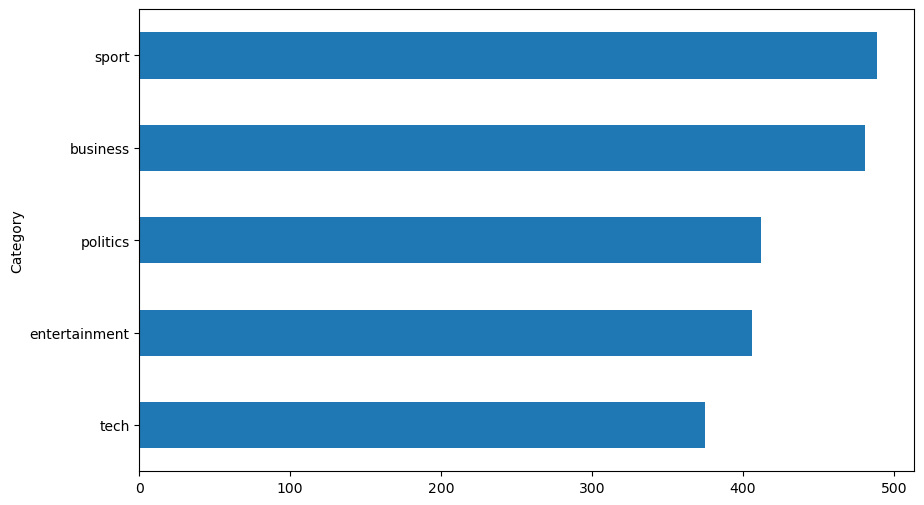

In [5]:
data.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

In [6]:
# Remove all punctuations from the text
import string as st

def remove_punct(text):
    return ("".join([ch for ch in text if ch not in st.punctuation]))

data['removed_punc'] = data['Text'].apply(lambda x: remove_punct(x))
data.head()

,ArticleId,Text,Category,removed_punc
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...


In [7]:
# Convert text to lower case tokens
import re

def tokenize(text):
    text = re.split('\s+' ,text)
    return [x.lower() for x in text]

data['tokens'] = data['removed_punc'].apply(lambda msg : tokenize(msg))
data.head()

,ArticleId,Text,Category,removed_punc,tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo..."


In [8]:
# Remove tokens of length less than 3
def remove_small_words(text):
    return [x for x in text if len(x) > 3 ]

data['larger_tokens'] = data['tokens'].apply(lambda x : remove_small_words(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former..."


In [9]:
# Remove stopwords by using NLTK corpus list
def remove_stopwords(text):
    return [word for word in text if word not in nltk.corpus.stopwords.words('english')]

data['clean_tokens'] = data['larger_tokens'].apply(lambda x : remove_stopwords(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former..."


In [10]:
# Apply lemmatization on tokens
from nltk import WordNetLemmatizer

def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

data['lemma_words'] = data['clean_tokens'].apply(lambda x : lemmatize(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de..."
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ..."
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma..."
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b..."
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ..."


In [11]:
# Create sentences to get clean text as input for vectors
def return_sentences(tokens):
    return " ".join([word for word in tokens])

data['clean_text'] = data['lemma_words'].apply(lambda x : return_sentences(x))
data.head()

,ArticleId,Text,Category,removed_punc,tokens,larger_tokens,clean_tokens,lemma_words,clean_text
0,1833,worldcom ex-boss launches defence lawyers defe...,business,worldcom exboss launches defence lawyers defen...,"[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launches, defence, lawyers,...","[worldcom, exboss, launch, defence, lawyer, de...",worldcom exboss launch defence lawyer defendin...
1,154,german business confidence slides german busin...,business,german business confidence slides german busin...,"[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slides, german,...","[german, business, confidence, slide, german, ...",german business confidence slide german busine...
2,1101,bbc poll indicates economic gloom citizens in ...,business,bbc poll indicates economic gloom citizens in ...,"[bbc, poll, indicates, economic, gloom, citize...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizens, m...","[poll, indicates, economic, gloom, citizen, ma...",poll indicates economic gloom citizen majority...
3,1976,lifestyle governs mobile choice faster bett...,tech,lifestyle governs mobile choice faster bett...,"[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...","[lifestyle, governs, mobile, choice, faster, b...",lifestyle governs mobile choice faster better ...
4,917,enron bosses in $168m payout eighteen former e...,business,enron bosses in 168m payout eighteen former en...,"[enron, bosses, in, 168m, payout, eighteen, fo...","[enron, bosses, 168m, payout, eighteen, former...","[enron, bosses, 168m, payout, eighteen, former...","[enron, boss, 168m, payout, eighteen, former, ...",enron boss 168m payout eighteen former enron d...


### Model and Evaluation Phase

In [12]:
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity

In [13]:
# Balancing the dataset to have the same number of documents for each query
from sklearn.utils import resample

def balance_data(data, category_col):
    categories = data[category_col].unique()
    min_category_count = data[category_col].value_counts().min()

    balanced_data = []

    for category in categories:
        category_data = data[data[category_col] == category]
        category_data_balanced = resample(category_data, replace=False, n_samples=min_category_count, random_state=42)
        balanced_data.append(category_data_balanced)

    return pd.concat(balanced_data)

In [14]:
data = balance_data(data, 'Category')
balanced_data = data[['clean_text', 'Category']]
balanced_data.groupby(['Category']).size().sort_values(ascending=True)

Category
business         375
entertainment    375
politics         375
sport            375
tech             375
dtype: int64

<Axes: ylabel='Category'>

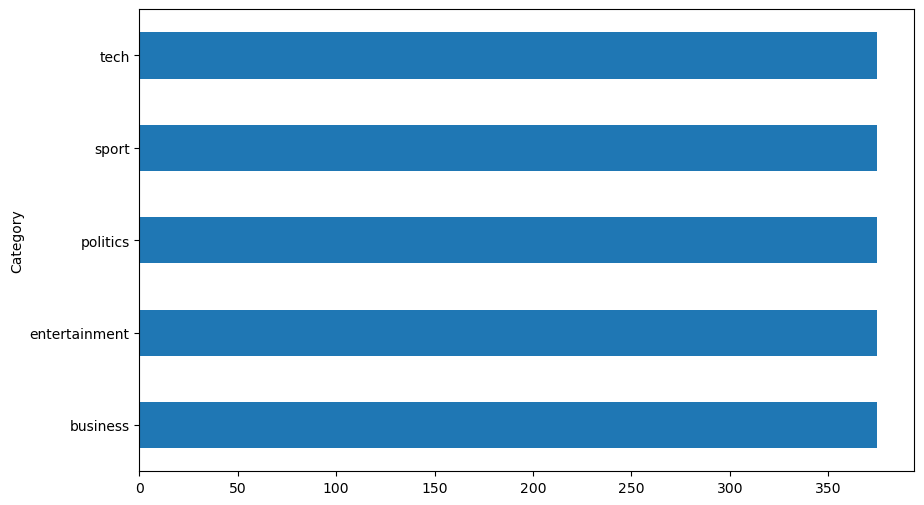

In [15]:
balanced_data.groupby(['Category']).size().sort_values(ascending=True).plot(kind='barh', figsize=(10, 6))

In [16]:
#vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.9, min_df=5)
#vectorizer = TfidfVectorizer(norm='l2', use_idf=False)
vectorizer = TfidfVectorizer(stop_words='english')
document_vectors = vectorizer.fit_transform(balanced_data['clean_text'])

In [17]:
topics = {
    # Sport
    'sport': ['sport', 'game', 'year', 'first', 'player', 'world', 'england', 'time', 'play', 'match', 'team', 'side',
              'second', 'champion', 'good', 'three', 'week', 'ireland', 'final', 'coach', 'injury', 'season', 'club',
              'france', 'wale', 'people', 'rugby', 'open', 'great', 'nation', 'month', 'point', 'united', 'title', 
              'minute', 'start', 'victory', 'chance', 'chelsea', 'international', 'played', 'scotland', 'best', 'home', 
              'league', 'championship', 'five', 'olympic', 'face', 'goal', 'playing', 'record', 'arsenal', 'country',
              'decision', 'place', 'test', 'manager', 'race', 'break', 'return', 'grand', 'beat', 'european', 'four',
              'away', 'former', 'service', 'third'],
    
    # Business
    'business': ['business', 'year', 'company', 'firm', 'market', 'country', 'government', 'sale', 'bank', 'price', 
                 'economy', 'growth', 'month', 'share', 'economic', 'world', 'rate', 'people', 'time', 'analyst', 
                 'chief', 'first', 'deal', 'profit', 'dollar', 'rise', 'china', 'euro', 'offer', 'cost', 'plan', 
                 'executive', 'group', 'make', 'three', 'week', 'figure', 'financial', 'minister', 'report', 
                 'investment', 'stock', 'many', 'india', 'yukos', 'interest', 'high', 'state', 'debt', 'demand', 
                 'european', 'well', 'trade', 'foreign', 'million', 'move', 'strong', 'director', 'president', 'good',
                 'industry', 'number', 'quarter', 'budget', 'fall', 'former', 'news', 'work', 'money', 'need', 'investor'],
    
    # Entertainment
    'entertainment': ['entertainment', 'film', 'year', 'best', 'award', 'people', 'show', 'music', 'star', 'time', 
                      'number', 'actor', 'band', 'director', 'world', 'album', 'like', 'company', 'sale', 'million', 
                      'government', 'oscar', 'song', 'chart', 'home', 'record', 'movie', 'role', 'actress', 'place',
                      'play', 'right', 'week', 'single', 'game', 'group', 'life', 'singer', 'work', 'prize', 'country',
                      'industry', 'good', 'festival', 'nomination', 'party', 'money', 'child', 'office', 'comedy', 'rock', 
                      'winner', 'series', 'book', 'woman', 'producer', 'news', 'love', 'performance', 'musical'],
    
    # Politics
    'politics': ['politics', 'labour', 'people', 'government', 'party', 'election', 'year', 'blair', 'minister', 'tory',
                 'plan', 'time', 'brown', 'lord', 'country', 'public', 'home', 'issue', 'leader', 'right', 'game', 'secretary', 
                 'general', 'service', 'prime', 'week', 'world', 'change', 'campaign', 'like', 'conservative', 'bill', 'spokesman',
                 'chancellor', 'police', 'report', 'child', 'claim', 'council', 'power', 'vote', 'need', 'liberal', 'democrat', 
                 'case', 'policy', 'member', 'court', 'problem', 'european', 'group', 'former', 'house', 'help', 'local', 'system',
                 'decision', 'school', 'kennedy', 'news', 'office', 'place', 'state'],
    
    # Tech
    'tech': ['tech', 'technology', 'people', 'year', 'game', 'mobile', 'phone', 'service', 'firm', 'user', 'time', 'music', 'first',
             'company', 'computer', 'software', 'system', 'world', 'like', 'digital', 'number', 'million', 'network', 'used', 'player',
             'market', 'work', 'online', 'consumer', 'microsoft', 'site', 'internet', 'device', 'month', 'broadband', 'website', 'video',
             'gadget', 'show', 'data', 'home', 'information', 'medium', 'machine', 'search', 'security', 'european', 'content', 'research',
             'report', 'group', 'news', 'help', 'virus', 'industry', 'problem', 'email', 'mean', 'program', 'message', 'play', 'camera', 
             'different', 'three', 'apple', 'europe', 'offer', 'sale']
}

In [18]:
users = [
    {'id': 1, 'interests': topics['sport']},
    {'id': 2, 'interests': topics['business']},
    {'id': 3, 'interests': topics['entertainment']},
    {'id': 4, 'interests': topics['politics']},
    {'id': 5, 'interests': topics['tech']},
    {'id': 6, 'interests': topics['sport'] + topics['business']},
    {'id': 7, 'interests': topics['entertainment'] + topics['politics']},
    {'id': 8, 'interests': topics['tech'] + topics['sport']},
    {'id': 9, 'interests': topics['business'] + topics['entertainment']},
    {'id': 10, 'interests': topics['politics'] + topics['tech'] + topics['business']}
]

Simple way of creating the users

In [19]:
# user_vectors = []
# for user in users:
#     interests = " ".join(user['interests'])
#     vector = vectorizer.transform([interests])
#     user_vectors.append(vector)

# lista_vecs = [user_vectors[i] for i in range(len(user_vectors))]

Creating the users by using the mean/max function

In [20]:
# import numpy as np
# from scipy.sparse import csr_matrix

# def aggregate_vectors(vectors):
#     return np.mean(vectors, axis=0)

# def max_aggregate_vectors(vectors):
#     return np.max(vectors, axis=0)

# user_vectors = []
# for user in users:
#     topic_vectors = []
#     for topic in user['interests']:
#         topic_vector = vectorizer.transform([topic]).toarray()
#         topic_vectors.append(topic_vector)
#     user_vector = max_aggregate_vectors(topic_vectors)
#     user_vectors.append(user_vector)

# user_vectors_sparse = [csr_matrix(user_vector) for user_vector in user_vectors]

# lista_vecs = user_vectors_sparse

#### Creating the users by using the Weighted Topic Frequency (WTF) method

This a creative approach for constructing user vectors that takes into account the uniqueness of each topic for the user.

1. Calculate the term frequency (TF) for each word in the user's interests.
2. Calculate the inverse topic frequency (ITF) for each word across all topics.
3. Calculate the Weighted Topic Frequency (WTF) for each word by multiplying its TF by its ITF.
4. Create the user vector by using the WTF values for each word in the user's interests.

Here's a step-by-step explanation:

1. Term Frequency (TF): Count the frequency of each word in the user's interests and normalize it by the total number of words in the user's interests.

2. Inverse Topic Frequency (ITF): For each word in the user's interests, calculate its presence in all topics. Then, compute the inverse of this presence (total number of topics / number of topics containing the word). This will give higher weights to words that are more unique to a user's interests.

3. Weighted Topic Frequency (WTF): Multiply the TF and ITF for each word to obtain the WTF value. This will emphasize words that are both frequent in the user's interests and unique to their topics.

4. User vector creation: Use the WTF values for each word in the user's interests to create the user vector. This can be done by transforming the user's interests (with WTF values) using the vectorizer.transform() function.

In [21]:
from collections import Counter

def calculate_tf(user_interests):
    word_count = Counter(user_interests)
    total_words = len(user_interests)
    tf = {word: count / total_words for word, count in word_count.items()}
    return tf

def calculate_itf(user_interests, topics):
    num_topics = len(topics)
    topic_presence = {word: 0 for word in user_interests}
    
    for topic_words in topics.values():
        for word in set(user_interests):
            if word in topic_words:
                topic_presence[word] += 1
    
    itf = {word: np.log(num_topics / presence) for word, presence in topic_presence.items()}
    return itf

def calculate_wtf(user_interests, topics):
    tf = calculate_tf(user_interests)
    itf = calculate_itf(user_interests, topics)
    wtf = {word: tf[word] * itf[word] for word in user_interests}
    return wtf

user_vectors = []
for user in users:
    wtf = calculate_wtf(user['interests'], topics)
    weighted_interests = " ".join([word for word, weight in wtf.items() for _ in range(int(weight * 100))])
    user_vector = vectorizer.transform([weighted_interests])
    user_vectors.append(user_vector)

lista_vecs = [user_vectors[i] for i in range(len(user_vectors))]

In [22]:
for user in lista_vecs:
    print(user)

  (0, 25262)	0.15625830612635827
  (0, 25058)	0.15414948246813331
  (0, 24606)	0.1481065966670571
  (0, 23740)	0.14608660209852956
  (0, 23449)	0.15280139291873382
  (0, 23301)	0.1311419718918413
  (0, 22377)	0.12348335286877822
  (0, 22204)	0.15149610717089765
  (0, 20912)	0.10921122569439558
  (0, 20890)	0.14781187821727268
  (0, 20799)	0.15886362408593277
  (0, 20386)	0.18129878600782984
  (0, 19941)	0.13461262609146796
  (0, 19299)	0.061101732964003334
  (0, 18958)	0.16552267678971536
  (0, 18027)	0.12634308123587487
  (0, 17951)	0.13934867289612488
  (0, 17947)	0.057764847123330895
  (0, 17946)	0.1374795761427019
  (0, 16832)	0.13133821592882694
  (0, 16743)	0.17750103729219355
  (0, 16067)	0.1359110407692308
  (0, 15481)	0.14840344306630956
  (0, 14938)	0.14257975860328131
  (0, 14719)	0.15023099050069558
  (0, 13891)	0.1673707653425341
  (0, 12884)	0.1581022495919438
  (0, 12732)	0.12267876657069347
  (0, 12550)	0.15280139291873382
  (0, 10903)	0.1265176591953807
  (0, 10859)	0.

In [23]:
predictions = []
predictions2 = []
for i in range(0, len(lista_vecs)):
    match = 0
    best_similarity = -1
    for j in range(0, document_vectors.shape[0]):
        document = document_vectors[j]
        similarity = cosine_similarity(document, lista_vecs[i])
        if similarity > best_similarity:
            best_similarity = similarity
            match = j
    predictions.append(balanced_data.iloc[match]['Category'])
    predictions2.append(balanced_data.iloc[match]['clean_text'])

In [27]:
correct_predictions = 0
for category, text, user in zip(predictions, predictions2, users):
    print()
    print("User: ", user['id'])
    print("Category Predicted: ", category)
    print("Recommended Text: ", text)
    print("User's Interests: ", user['interests'])
    if category == user['interests'][0]:
        correct_predictions += 1

print("\nAccuracy: ", correct_predictions/len(users))


User:  1
Category Predicted:  sport
Recommended Text:  celt savour grand slam prospect nation heralded order northern hemisphere rugby year wale ireland rather traditional gun france england face potential grand slam playoff three week time game cardiff wale must past scotland murrayfield ireland face insignificant task home fixture mercurial french noone know mood france lansdowne road march sublime first half wale ridiculous like period england twickenham mighty fallen england rugby summit month world champion 2003 grand slam winner lost nine match since heady night sydney face ignominy could amount wooden spoon playoff italy fortnight england enduring worst championship since captain richard hill dumped favour mike harrison three straight loss 1987 coach andy robinson took successful clive woodward september lost phalanx world star enduring toughest teething problem bedding style team year england ruled roost woeful wale lost five match nation game scotland italy 2004 wale recent c